 # MMA Data Preparation and Experiment Design



 This notebook documents the full preprocessing, imputation, and experiment creation pipeline

 for the MMA dataset. Each section includes modular code and narrative to support reproducibility.

 ## 1. Imports and Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
from sklearn.model_selection import train_test_split


 ## 2. Helper Functions

In [2]:
def impute_columns(df, columns, method="mean", knn_k=5):
    """
    Impute missing values in specified columns using 'mean', 'median', or 'knn'.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to impute.
        method (str): 'mean', 'median', or 'knn'. Default is 'mean'.
        knn_k (int): Number of neighbors for KNN imputation (used if method='knn').

    Returns:
        pd.DataFrame: DataFrame with imputed values.
    """
    if method in ["mean", "median"]:
        for col in columns:
            if col in df.columns and not pd.api.types.is_categorical_dtype(df[col]):
                if col in df.columns:
                    if method == "mean":
                        df.loc[:, col] = df[col].fillna(df[col].mean())
                    elif method == "median":
                        df.loc[:, col] = df[col].fillna(df[col].median())
    elif method == "knn":
        imputer = KNNImputer(n_neighbors=knn_k)
        df[columns] = imputer.fit_transform(df[columns])
    else:
        raise ValueError("Unsupported method. Choose from 'mean', 'median', or 'knn'.")

    return df

def mice_impute_low_missing(df, threshold=10.0):
    """
    Apply MICE imputation to columns with missing % below the threshold.
    Also return already complete columns.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        threshold (float): Max % of missing values to apply MICE

    Returns:
        Tuple:
            - imputed_cols (List[str]): Columns that were imputed
            - complete_cols (List[str]): Columns that had no missing values
            - imputed_df (pd.DataFrame): DataFrame with imputed values merged
    """
    df_copy = df.copy()
    
    # Compute missing percentage
    missing_pct = df_copy.isnull().mean() * 100

    # Columns with missing % > 0 and < threshold → to be imputed
    imputed_cols = missing_pct[(missing_pct > 0) & (missing_pct < threshold)].index.tolist()

    # Columns with 0% missing → already complete
    complete_cols = missing_pct[missing_pct == 0].index.tolist()

    # If nothing to impute, return early
    if not imputed_cols:
        return [], complete_cols, df_copy

    # Apply MICE on imputed_cols
    imputer = IterativeImputer(random_state=42)
    imputed_array = imputer.fit_transform(df_copy[imputed_cols])

    df_copy[imputed_cols] = pd.DataFrame(imputed_array, columns=imputed_cols, index=df.index)

    return imputed_cols, complete_cols, df_copy

def process_b12_and_kidney_labels(df):
    """
    Label Vitamin B12 and Kidney problem flags based on VITB12 and eGFR levels.

    Parameters:
        df (pd.DataFrame): Original DataFrame

    Returns:
        pd.DataFrame: A copy of the DataFrame with two new label columns
    """
    df_labeled = df.copy()

    # Label Vitamin B12 condition
    condition_b12 = (df_labeled["VITB12"] >= 200) & (df_labeled["VITB12"] <= 700)
    df_labeled["Vitamin_B12_Problem_Label"] = condition_b12.astype(str).replace({'True': '1', 'False': '0'})

    # Replace missing labels with '1' (assume problem if unknown)
    df_labeled["Vitamin_B12_Problem_Label"] = df_labeled["Vitamin_B12_Problem_Label"].fillna("1")

    # Label kidney problem based on eGFR
    df_labeled["Kidney_problem"] = ((df_labeled["eGFR"] < 60).astype(str)).replace({'True': '1', 'False': '0'})

    return df_labeled

def export_schema_to_yaml(df, path="schema.yaml"):
    # Convert pandas dtypes to simple Python/yaml-friendly types
    type_map = {
        "int64": "int",
        "Int64": "int",
        "float64": "float",
        "object": "str",
        "bool": "bool",
        "category": "category",
        "datetime64[ns]": "datetime"
    }

    schema = {col: type_map.get(str(dtype), str(dtype)) for col, dtype in df.dtypes.items()}

    # Write to YAML
    with open(path, "w") as f:
        yaml.dump(schema, f, default_flow_style=False)

    return schema


 ## 3. Load and Clean Raw Data

In [3]:
in_data_file = "labeled_MMA_data.csv"
df = pd.read_csv(in_data_file, index_col=0)

# Translate Dutch columns to English
column_translation = {
    "Leeftijd": "Age",
    "Geslacht": "Sex",
    "IJzergebrek": "Iron Deficiency",
}
df.rename(columns=column_translation, inplace=True)
df.drop(columns=["Source", "LIS"], inplace=True)


 ## 4. Label Engineering: Vitamin B12 and Kidney Problems

In [4]:
df = process_b12_and_kidney_labels(df)

categorical_cols = [
    "Vitamin_B12_Problem_Label", "Kidney_problem", "Classificatie_MMZ", "Sex", "Anemie"
]
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

schema = export_schema_to_yaml(df, "exported_schema.yaml")
df.to_csv(f"processed_{in_data_file}", index=False)


 ## 5. Data Overview and Missing Value Summary

In [5]:
key_cols = ["Age", "Sex", "KR", "eGFR", "VITB12", "MMZ", "Classificatie_MMZ", "Anemie", "HB", "MCV"]
print(df[key_cols].describe().to_markdown())


|       |        Age |         KR |        eGFR |    VITB12 |       MMZ |         HB |        MCV |
|:------|-----------:|-----------:|------------:|----------:|----------:|-----------:|-----------:|
| count | 14252      | 13472      | 13100       | 13911     | 14252     | 7356       | 7355       |
| mean  |    54.1337 |    76.7788 |    86.6975  |   267.824 |   309.624 |    8.13736 |   91.6024  |
| std   |    22.1598 |    24.7216 |    23.2991  |   169.255 |   487.191 |    1.07305 |    6.23591 |
| min   |     2      |    17      |     6.95925 |    74     |    46     |    2       |   55.4     |
| 25%   |    35      |    63      |    71.6695  |   190     |   163     |    7.5     |   88.5     |
| 50%   |    55      |    72      |    87.4709  |   222     |   223.05  |    8.2     |   91.9     |
| 75%   |    73      |    85      |   103       |   256     |   325.125 |    8.8     |   95       |
| max   |   105      |   668      |   158.786   |  1476     | 19568.6   |   12       |  127       |


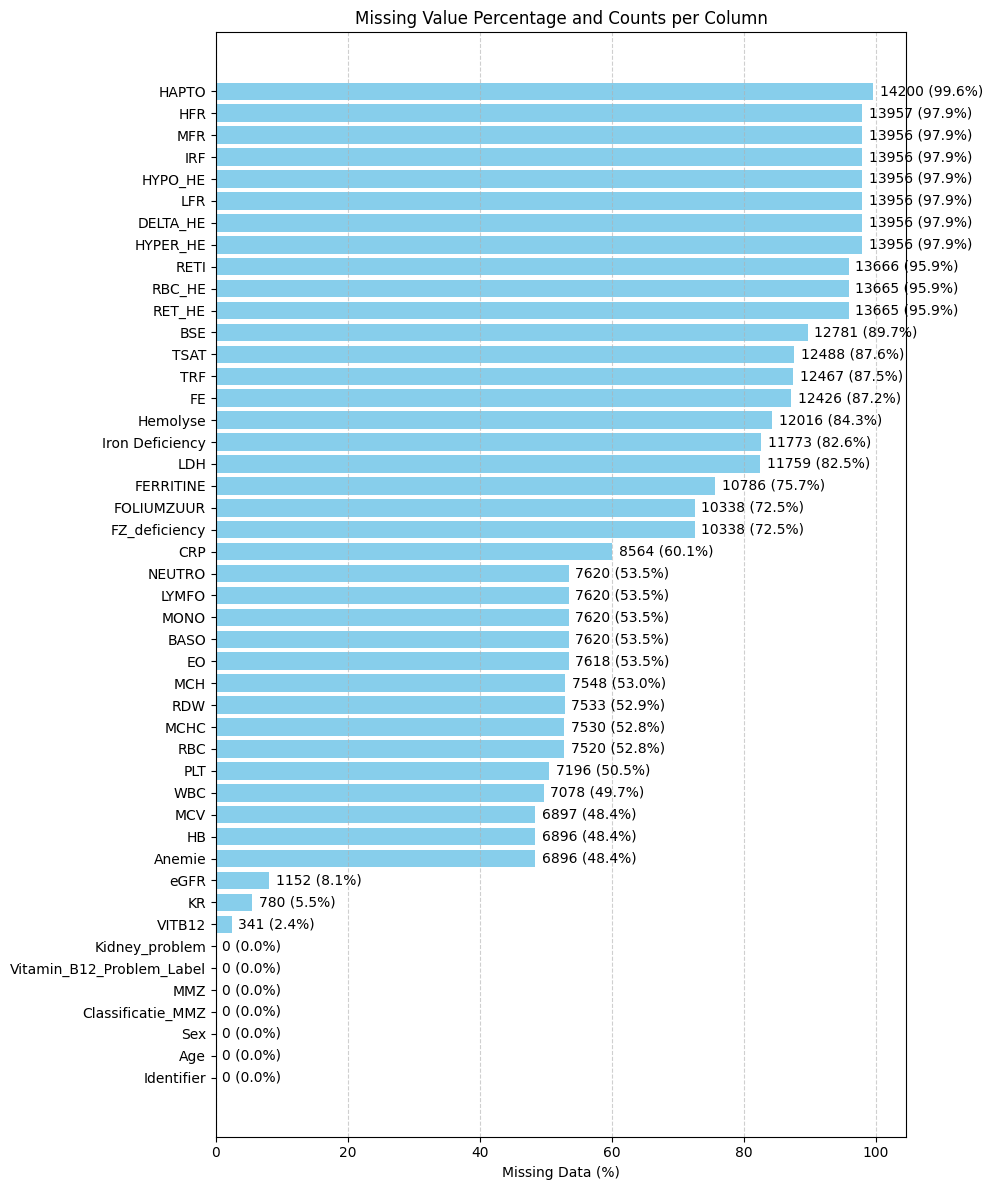

In [6]:
missing_counts = df.isnull().sum()
missing_ratios = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_counts,
    'Missing %': missing_ratios.round(2)
}).sort_values(by='Missing %', ascending=True)

plt.figure(figsize=(10, 12))
bars = plt.barh(missing_df.index, missing_df['Missing %'], color='skyblue')
for bar, (count, perc) in zip(bars, zip(missing_df['Missing Values'], missing_df['Missing %'])):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
             f'{int(count)} ({perc:.1f}%)', va='center')
plt.xlabel('Missing Data (%)')
plt.title('Missing Value Percentage and Counts per Column')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


 ## 6. Assign Group Labels Based on Missing Data Severity

In [7]:
def classify_missing(pct):
    if pct > 65: return 'Third'
    elif pct > 30: return 'Secondary'
    elif pct > 10: return 'Primary'
    else: return 'Primary'

missing_df["Group"] = missing_df["Missing %"].apply(classify_missing)
missing_df = missing_df.sort_values(by='Missing %', ascending=False)


 ## 7. Create Experiment Variants

 ### Experiment 1: Primary Columns Only

In [8]:
primary_cols = missing_df[missing_df["Group"] == "Primary"].index.tolist()
primary_df = df[primary_cols]
df_experiment_1_1 = impute_columns(primary_df, ["KR", "eGFR", "VITB12"], method="mean")
df_experiment_1_1.to_csv("primary_columns_impute_missing.csv", index=False)

df_experiment_1_2 = df[primary_cols].dropna()
df_experiment_1_2.to_csv("primary_columns_drop_missing.csv", index=False)


/var/folders/5f/7zn60cf53sxc74yn0mv8wdf80000gn/T/ipykernel_6302/481949845.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if col in df.columns and not pd.api.types.is_categorical_dtype(df[col]):


 ### Experiment 2: Primary + Secondary Columns

In [9]:
selected_cols = missing_df[missing_df["Group"].isin(["Primary", "Secondary"])].index.tolist()
df_experiment_2_1 = df[selected_cols].dropna()
df_experiment_2_1.to_csv("primary_secondary_columns_drop_missing.csv", index=False)


 ### Experiment 3: Primary + Lab Features

In [10]:
lab_cols = ["HB", "MCV", "CRP"]
selected_cols = primary_cols + lab_cols
df_experiment_3_1 = impute_columns(df[selected_cols], selected_cols, method="mean")
df_experiment_3_1.to_csv("primary_columns_hb_mcv_crp_impute_missing.csv", index=False)

df_experiment_3_2 = df[selected_cols].dropna()
df_experiment_3_2.to_csv("primary_columns_hb_mcv_crp_drop_missing.csv", index=False)


/var/folders/5f/7zn60cf53sxc74yn0mv8wdf80000gn/T/ipykernel_6302/481949845.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if col in df.columns and not pd.api.types.is_categorical_dtype(df[col]):


 ### Experiment 4: MICE-Based Imputation

In [11]:
for col in df.select_dtypes(include="category").columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

cols_to_impute, complete_cols, df_mice = mice_impute_low_missing(df, threshold=10)
experiment_4_1 = df_mice[complete_cols + cols_to_impute]
experiment_4_1.to_csv("mice_with_columns_missing_lt_10.csv", index=False)

cols_to_impute, complete_cols, df_mice = mice_impute_low_missing(df, threshold=65)
experiment_4_2 = df_mice[complete_cols + cols_to_impute]
experiment_4_2.to_csv("mice_with_columns_missing_lt_65.csv", index=False)


/Users/galactica/miniconda3/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


 ## 8. Summary: Dataset Shapes and Test IDs

In [12]:
file_names = [
    "labeled_MMA_data.csv",
    "processed_labeled_MMA_data.csv",
    "primary_columns_drop_missing.csv",
    "primary_columns_impute_missing.csv",
    "primary_columns_hb_mcv_crp_drop_missing.csv",
    "primary_columns_hb_mcv_crp_impute_missing.csv",
    "primary_secondary_columns_drop_missing.csv",
    "mice_with_columns_missing_lt_10.csv",
    "mice_with_columns_missing_lt_65.csv"
]
shape_info = []
dfs = []
for file in file_names:
    try:
        df = pd.read_csv(file)
        dfs.append(df)
        shape_info.append((file, df.shape[0], df.shape[1]))
    except Exception as e:
        shape_info.append((file, "Error", str(e)))

shape_df = pd.DataFrame(shape_info, columns=["File", "Rows", "Columns"])
print(tabulate(shape_df, headers='keys', tablefmt='pretty'))


+---+-----------------------------------------------+-------+---------+
|   |                     File                      | Rows  | Columns |
+---+-----------------------------------------------+-------+---------+
| 0 |             labeled_MMA_data.csv              | 14252 |   49    |
| 1 |        processed_labeled_MMA_data.csv         | 14252 |   46    |
| 2 |       primary_columns_drop_missing.csv        | 12787 |   10    |
| 3 |      primary_columns_impute_missing.csv       | 14252 |   10    |
| 4 |  primary_columns_hb_mcv_crp_drop_missing.csv  | 5195  |   13    |
| 5 | primary_columns_hb_mcv_crp_impute_missing.csv | 14252 |   13    |
| 6 |  primary_secondary_columns_drop_missing.csv   | 4662  |   25    |
| 7 |      mice_with_columns_missing_lt_10.csv      | 14252 |   11    |
| 8 |      mice_with_columns_missing_lt_65.csv      | 14252 |   25    |
+---+-----------------------------------------------+-------+---------+


In [13]:
id_sets = [set(df["Identifier"].dropna()) for df in dfs]
common_ids = set.intersection(*id_sets)
print(f"Number of common Identifiers: {len(common_ids)}")

df_common = df[df["Identifier"].isin(common_ids)].copy()
class_counts = df_common["Classificatie_MMZ"].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df_common_filtered = df_common[df_common["Classificatie_MMZ"].isin(valid_classes)]

X = df_common_filtered[["Identifier"]]
y = df_common_filtered["Classificatie_MMZ"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_test["Identifier"].to_csv("test_ids_20pct.csv", index=False, header=True)


Number of common Identifiers: 4662
